In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def wait_for_key(key=32):
    # while key != cv2.waitKey(30):
    #     pass
    cv2.waitKey(0)

path = 'chief/data'
%matplotlib notebook

<IPython.core.display.Javascript object>


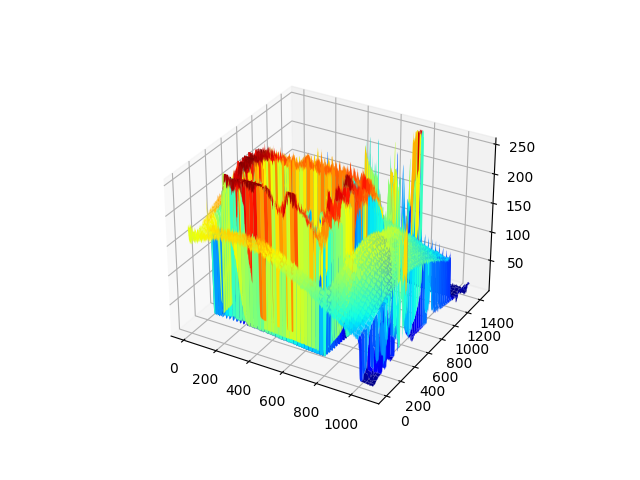

255 1 103.67643711419753 71.465675722097


<IPython.core.display.Javascript object>


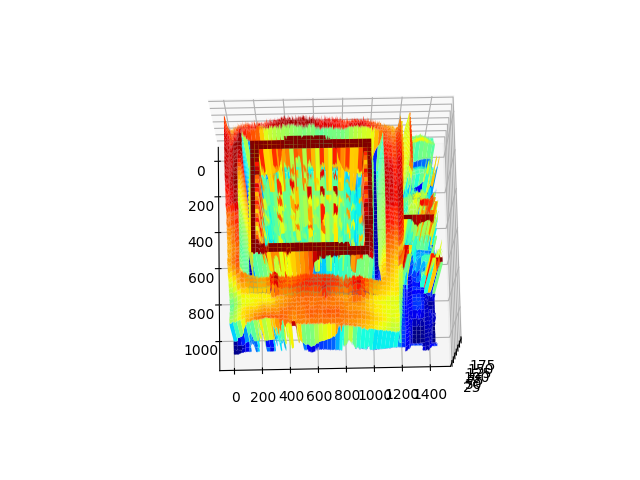

<IPython.core.display.Javascript object>


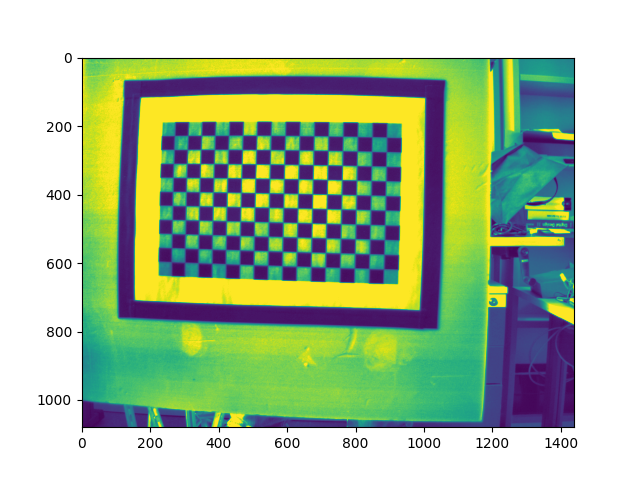

<IPython.core.display.Javascript object>


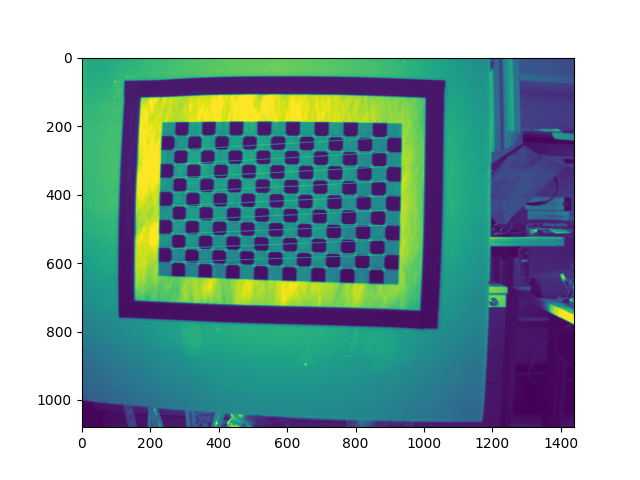

In [12]:
with open(path + '/calibration_images/13_29_38_022.raw', 'rb') as f:
    img_real = np.fromfile(f, dtype=np.uint8)
    img_real = img_real.reshape((1080, 1440))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
XX, YY = np.meshgrid(np.arange(1440), np.arange(1080))
ax.plot_surface(YY, XX, img_real, cmap='jet')
print(np.max(img_real), np.min(img_real), np.mean(img_real), np.std(img_real))
img_for_detect = img_real.copy()
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 8
# ret, label, center = cv2.kmeans(
#     img_for_detect, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
# img_for_detect = center[label.flatten()]
# img_for_detect = img_for_detect.reshape((1080, 1440))
# mean = np.mean(img_for_detect)
# std = np.std(img_for_detect)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_for_detect = clahe.apply(img_for_detect)
mean, std = np.mean(img_for_detect), np.std(img_for_detect)
img_for_detect[img_for_detect > mean + std] = mean + std
# img_for_detect[np.abs(img_for_detect - mean) > std] = mean + std
# img_for_detect[img_for_detect>20] = 20 
# img_for_detect[img_for_detect <= mean] = img_for_detect[img_for_detect <= mean] // 10 * 10
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(YY, XX, img_for_detect, cmap='jet')
plt.figure()
plt.imshow(img_for_detect)
GRID = (16, 10)
found, corners = cv2.findChessboardCornersSB(
    img_for_detect, GRID, cv2.CALIB_CB_ADAPTIVE_THRESH)
img_captured_corners = img_real.copy()
cv2.drawChessboardCorners(img_captured_corners, GRID, corners, found)
plt.figure()
plt.imshow(img_captured_corners)


# generate test

In [ ]:

def distort_func(x, y, **params):
    a = params['a']
    b = params['b']
    center = params['center']
    rmax2 = np.dot(params['shape'], params['shape'])
    point = np.array([x, y]) - center
    rd2 = np.dot(point, point)
    return point * (a + b * rd2/rmax2) + center

def create_distort_map(shape, **params):
    map_x = np.zeros(shape[0:2], dtype=np.float32)
    map_y = np.zeros(shape[0:2], dtype=np.float32)
    for y in range(shape[0]):
        for x in range(shape[1]):
            x_new, y_new = distort_func(x, y, **params, shape=shape)
            map_x.itemset((y, x), x_new)
            map_y.itemset((y, x), y_new)
    return map_x, map_y

# test image
checkboard = cv2.imread(path + '/' + 'checkboard.png', cv2.IMREAD_GRAYSCALE)
# real raw image
# with open(path + '/' + 'examples' + '/' + '11_42_24_483.raw', 'rb') as f:
#     img = np.fromfile(f, dtype=np.uint8)
#     img = img.reshape((1080, 1440))

print(checkboard.shape)


In [ ]:
cv2.imshow('checkboard', checkboard)
for b in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    wait_for_key()
    params = {
        'a': 1,
        'b': b,
        'center': np.array([checkboard.shape[0] / 2, checkboard.shape[1] / 2])
    }
    map_x, map_y = create_distort_map(checkboard.shape, **params)
    checkboard_distorted = cv2.remap(
        checkboard, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    cv2.imshow('checkboard', checkboard_distorted)


In [ ]:
params = {
    'a': 1,
    'b': 8,
    'center': np.array([checkboard.shape[0] / 2, checkboard.shape[1] / 2])
}
map_x, map_y = create_distort_map(checkboard.shape, **params)
checkboard_distorted = cv2.remap(
    checkboard, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
# checkboard_distorted = cv2.remap(
#     checkboard, map_x, map_y, cv2.INTER_LINEAR)
# checkboard_distorted = cv2.GaussianBlur(
#    checkboard_distorted, (3, 3), cv2.BORDER_DEFAULT)
cv2.imshow('checkboard', checkboard_distorted)
wait_for_key()

cv2.imwrite(path + '/' + 'checkboard_distorted.png', checkboard_distorted)


# calibration test

In [ ]:
img_captured = cv2.imread(
    path + '/' + 'checkboard_distorted.png', cv2.IMREAD_GRAYSCALE)
img_captured = cv2.resize(img_captured, (350, 350))

GRID = (12, 12)

found, corners = cv2.findChessboardCorners(
    img_captured, GRID, cv2.CALIB_CB_ADAPTIVE_THRESH)
img_captured_corners = img_captured.copy()
cv2.drawChessboardCorners(img_captured_corners, GRID, corners, found)
cv2.imshow('img_captured_corners', img_captured_corners)
# wait_for_key()
# corners1 = corners.copy() 
# corners = cv2.cornerSubPix(img_captured, corners, (5, 5), (-1, -1),
#                             (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
# img_captured_corners = img_captured.copy()
# cv2.drawChessboardCorners(img_captured_corners, GRID, corners1, found)
# cv2.imshow('img_captured_corners', img_captured_corners)
# wait_for_key()


In [ ]:
def generate_obj_points(grid):
    objp = np.zeros((grid[0] * grid[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid[0], 0:grid[1]].T.reshape(-1, 2)*20
    return objp

objs = [generate_obj_points(GRID)]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objs, [corners], img_captured.shape[::-1], None, None)
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, cv2.getOptimalNewCameraMatrix(
    mtx, dist, img_captured.shape[::-1], 0)[0], img_captured.shape[::-1], cv2.CV_32FC1)
img_undistorted = cv2.remap(
    img_captured, mapx, mapy, cv2.INTER_LINEAR)
cv2.imshow('img_undistorted', img_undistorted)
wait_for_key()

In [ ]:
def remap_sub_rect(img, map_x, map_y, sub_rect):
    # ind = sub_rect + np.hstack(([0, 0], sub_rect[2:4]))
    ind = sub_rect
    sub_map_x = map_x[ind[1]:ind[3], ind[0]:ind[2]]
    sub_map_y = map_y[ind[1]:ind[3], ind[0]:ind[2]]
    sub_img_undistorted = cv2.remap(
        img, sub_map_x, sub_map_y, cv2.INTER_LINEAR)
    return sub_img_undistorted

def draw_remapped_sub_rect(img, img_subrect, sub_rect):
    # img[sub_rect[1]:sub_rect[3], sub_rect[0]:sub_rect[2]] = cv2.resize(
    #     img_subrect, (sub_rect[2] - sub_rect[0], sub_rect[3] - sub_rect[1]))
    img[sub_rect[1]:sub_rect[3], sub_rect[0]:sub_rect[2]] = img_subrect

img_undistorted = img_captured.copy()

sub_rect = np.array([150, 100, 170, 120])
img_subrect = remap_sub_rect(img_undistorted, mapx, mapy, sub_rect)
draw_remapped_sub_rect(img_undistorted, img_subrect, sub_rect)

plt.figure()
plt.imshow(img_undistorted, cmap='gray')

# homographic rotation and translation

In [ ]:
w, h = img_undistorted.shape
alpha = np.pi/3
A1 = np.array([[1, 0, -w/2], [0, 1, -h/2], [0, 0, 0], [0, 0, 1]], np.float32)
Rx = np.array([[1, 0, 0, 0], [0, np.cos(alpha), -np.sin(alpha), 0], [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1]], np.float32)
Ry = np.array([[np.cos(alpha), 0, -np.sin(alpha), 0], [0, 1, 0, 0],
              [np.sin(alpha), 0, np.cos(alpha), 0], [0, 0, 0, 1]], np.float32)
A2 = np.array([[1, 0, 0, w/2], [0, 1, 0, h/2], [0, 0, 0, 1]], np.float32)
transfo = A2 @ (Ry @ (Rx @ A1))
# input_pts = np.float32([[50, 50], [50, 350], [300, 350], [300, 50]])
# output_pts = np.float32([[0, 0],
#                         [0, h - 1],
#                         [w - 1, h - 1],
#                         [w - 1, 0]])
# transfo = cv2.getPerspectiveTransform(input_pts, output_pts)

img_perspective = cv2.warpPerspective(
    img_undistorted, transfo, (w, h), cv2.INTER_CUBIC)
plt.imshow(img_perspective, cmap='gray')

# subpixel precision

In [ ]:
def inverse_line_func(pt1, pt2):
    diff = pt2 - pt1
    if diff[1] == 0:
        return lambda y: (pt1[0]+pt2[0])/2
    else:
        return lambda y: (y - pt1[1]) / diff[1] * diff[0] + pt1[0]

def linear_gradient_interp(img, sub_rect):
    assert sub_rect[2] - sub_rect[0] == sub_rect[3] - sub_rect[1]
    assert sub_rect[2] - sub_rect[0] == 3
    sumx = np.sum(img[sub_rect[1]:sub_rect[3], sub_rect[0]:sub_rect[2]], axis=0)
    sumy = np.sum(img[sub_rect[1]:sub_rect[3], sub_rect[0]:sub_rect[2]], axis=1)
    def interp_gradient(x):
        assert(x[1]>x[0] and x[1]>x[2] and 'midpoint must be the largest')
        dsum = np.diff(x)/2
        print(dsum)
        return inverse_line_func(np.array([-1/2, dsum[0]]), np.array([1/2, dsum[1]]))(0)
    return np.array([interp_gradient(sumx), interp_gradient(sumy)])+sub_rect[:2]+1

img = np.arange(9).reshape((3, 3))
img[1, 1] = 100
print(img)
sub_rect = np.array([0, 0, 3, 3])
linear_gradient_interp(img, sub_rect)
